<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/machine%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. CNN_LSTM + sliding window (5)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

#1. data
np.random.seed(42) # 매번 돌릴때마다 같은 결과 나오도록 seed
days = 30 # 5분 단위 한 달 데이터
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')

# CPU 패턴 (주기적인 패턴 + 노이즈 + 증가 추세)
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

# 2. 정규화
scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# 3. sequence 생성 (시계열 -> 예측)
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X, y = create_sequences(scaled_cpu, past_steps, future_steps)

# 8:2 학습
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

# 5. CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(future_steps))  # future step에서의 CPU 예측
model.compile(optimizer='adam', loss='mse')


model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), # -1: numpy가 알아서 차원 계산하도록
          epochs=50, batch_size=16, verbose=1)


# 6. prediction
pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)  # future_step (5) step 예측
y_true = y_test.reshape(-1, future_steps)



/tmp/ipython-input-5-3466844006.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


입력 X_train shape: (6892, 20, 1), 출력 y_train shape: (6892, 5, 1)
Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0399
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2190e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2330e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1573e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0857e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0538e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.8376e-04
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7254e-04
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.5885e-04
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6810e-04
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6478e-04
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5290e-04
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5155e-04
Epoch 14/50
4

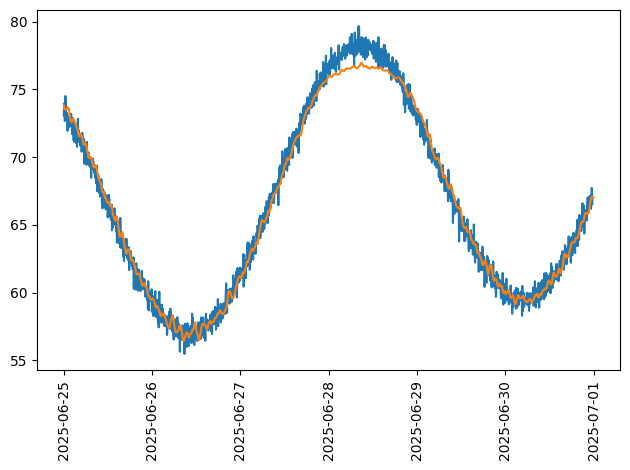

In [ ]:
future_steps = 5
future_interval = 5  # 5분 단위

# 테스트셋 시작 index
test_start_idx = train_size + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

all_future_times = []
all_future_preds = []

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

# 동일 시간에서의 예측값 평균 (sliding window라서 겹치는 부분 발생)
pred_df_mean = pred_df.groupby("time").mean().sort_index()

# # df[['cpu']] → scaler.inverse_transform 하면 shape=(N,1)
# # df_inv = scaler.inverse_transform(df[['cpu']].values)

# # 1D로 변환 후 Series 생성
# df_inv_series = df[['cpu']].values

y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)

shifted_true_times = [t + pd.Timedelta(minutes=5) for t in test_time_index]
plt.plot(shifted_true_times, y_true_inv[:,0], label="Shifted True (5min ahead)")
plt.plot(pred_df_mean.index, pred_df_mean['pred'], label="Pred")

# label_x 세로
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


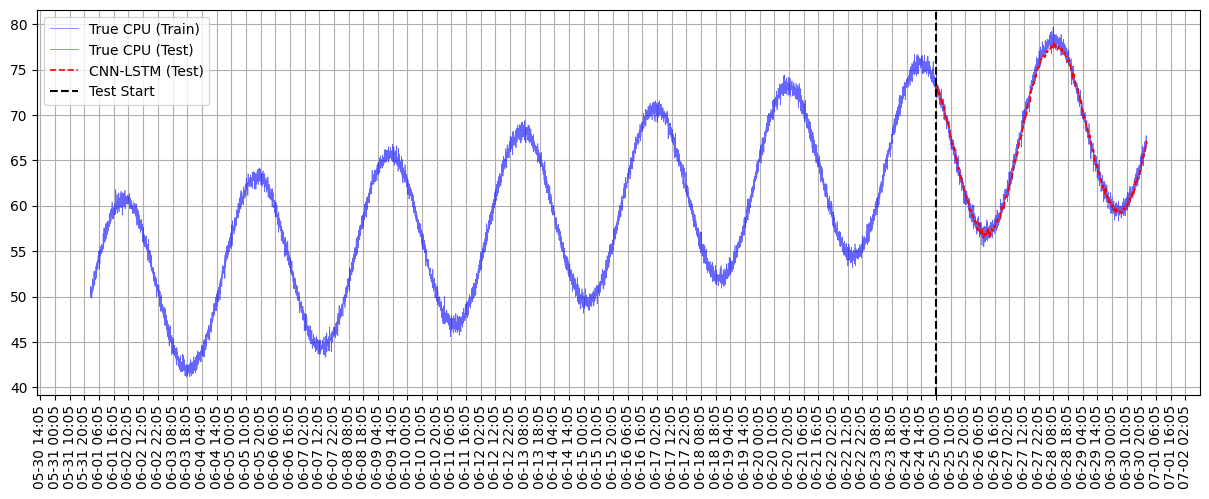

In [ ]:
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(y_true_inv[:,0].flatten(), index=test_time_index) # test data (True)

test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(15,5))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600)) # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.show()


Result for Moving Average
MAE : 0.5517
RMSE: 0.6882

Result for CNN-LSTM
MAE : 0.5051
RMSE: 0.6320


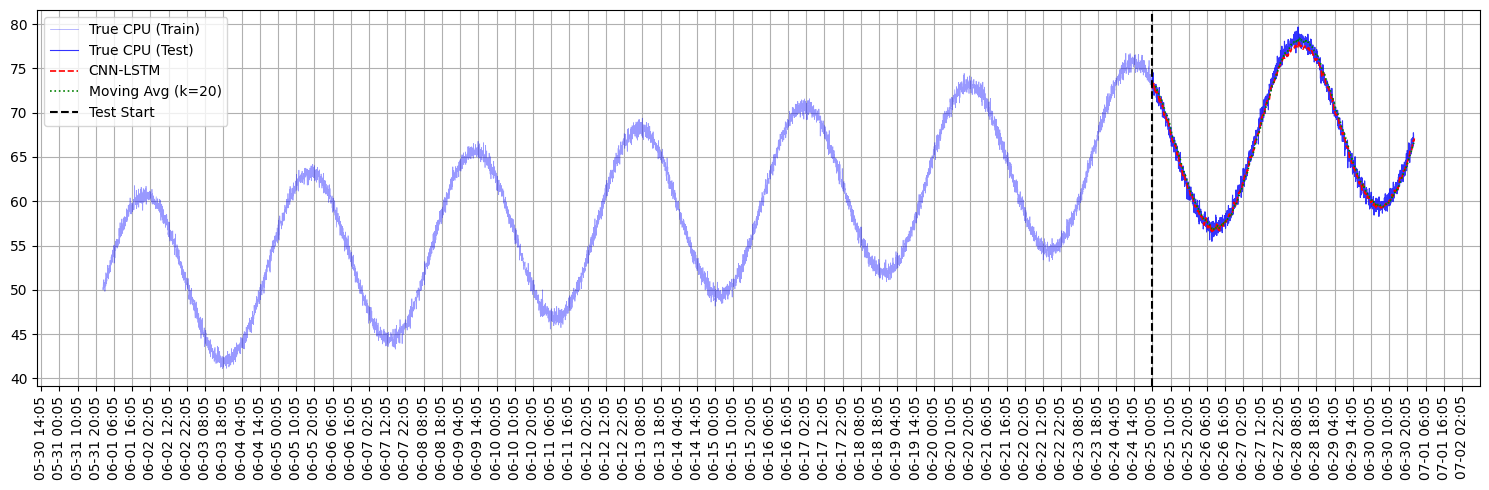

In [ ]:
# 정확도 분석

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Moving Average 방식
k = 20  # 최근 20 step 평균 (원하는 값으로 조절)
moving_avg_pred = []

for i in range(k, len(test_series_true)):
    moving_avg_pred.append(np.mean(test_series_true[i-k:i]))  # k개 평균

moving_avg_pred_series = pd.Series(moving_avg_pred, index=test_time_index[k:])  # k step 이후부터 가능


true_vals = test_series_true.values
cnn_pred_vals = test_series_pred.values[:len(true_vals)]  # 길이 맞춤

mae_cnn = mean_absolute_error(true_vals, cnn_pred_vals)
rmse_cnn = np.sqrt(mean_squared_error(true_vals, cnn_pred_vals))
r2_cnn = r2_score(true_vals, cnn_pred_vals)

true_vals_ma = true_vals[k:]  # k step 이후부터만 비교 가능
mae_ma = mean_absolute_error(true_vals_ma, moving_avg_pred)
rmse_ma = np.sqrt(mean_squared_error(true_vals_ma, moving_avg_pred))
r2_ma = r2_score(true_vals_ma, moving_avg_pred)

print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")
# print(f"R²  : {r2_ma:.4f}")

print("\nResult for CNN-LSTM")
print(f"MAE : {mae_cnn:.4f}")
print(f"RMSE: {rmse_cnn:.4f}")
# print(f"R²  : {r2_cnn:.4f}")

fig, ax = plt.subplots(figsize=(15,5))

plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.4, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.8, linewidth=0.8)
plt.plot(test_series_pred, label="CNN-LSTM", color="red", linestyle="--", linewidth=1.2)
plt.plot(moving_avg_pred_series, label=f"Moving Avg (k={k})", color="green", linestyle=":", linewidth=1.2)

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")  # test 시작선

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))  # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기

입력 X_train shape: (6892, 20, 1), 출력 y_train shape: (6892, 5, 1)


/tmp/ipython-input-26-609321960.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 3, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,477 (662.02 KB)

 Trainable params: 169,477 (662.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0239
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 6.8680e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.0580e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 5.5853e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 5.0162e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.0751e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.7146e-04
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.6038e-04
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.4876e-04
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.7057e-04
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.1959e-04
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.0137e-04
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.9222e-04
Epoch 14/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - lo

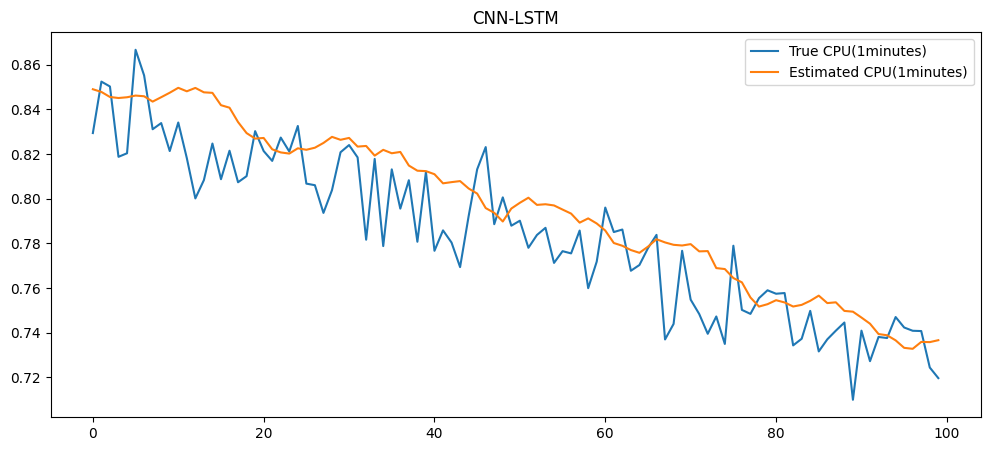

In [ ]:
#1. data
# datapoint 갯수 많으므로 sliding window 방식
np.random.seed(42)
days = 30 # 5분 단위 한 달 데이터
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미

cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X, y = create_sequences(scaled_cpu, past_steps, future_steps)

train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

# 5. CNN-LSTM
# CNN을 더쌓아
from tensorflow.keras.layers import Bidirectional, Dropout

model = Sequential()

# CNN 두 층
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))  # 추가 CNN
model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM --> 양방향 패턴 학습
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # 첫번째 BiLSTM
model.add(Dropout(0.2))  # 과적합 방지
model.add(Bidirectional(LSTM(32)))  # 두번째 BiLSTM

model.add(Dense(64, activation='relu'))  # 추가 Dense
model.add(Dense(future_steps))  # 미래 step 예측

model.compile(optimizer='adam', loss='mse')

print(model.summary())

model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), # -1: numpy가 알아서 차원 계산하도록
          epochs=50, batch_size=16, verbose=1)


# 6. prediction
pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)  # 미래 5분 예측
y_true = y_test.reshape(-1, future_steps)



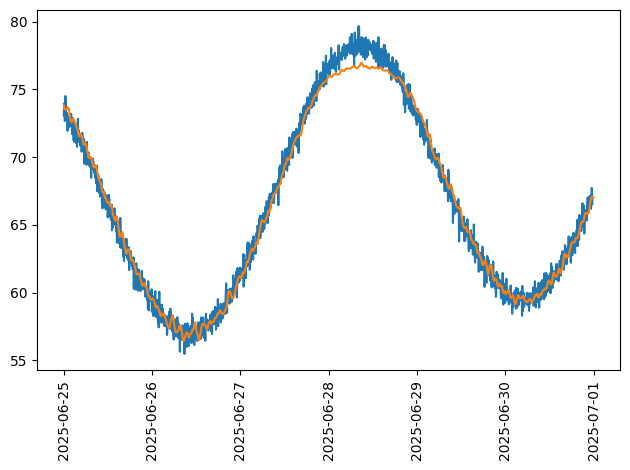

In [ ]:
future_steps = 5
future_interval = 5  # 5분 단위

# 테스트셋 시작 index
test_start_idx = train_size + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

all_future_times = []
all_future_preds = []

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

# 동일 시간에서의 예측값 평균 (sliding window라서 겹치는 부분 발생)
pred_df_mean = pred_df.groupby("time").mean().sort_index()

# # df[['cpu']] → scaler.inverse_transform 하면 shape=(N,1)
# # df_inv = scaler.inverse_transform(df[['cpu']].values)

# # 1D로 변환 후 Series 생성
# df_inv_series = df[['cpu']].values

y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)
shifted_true_times = [t + pd.Timedelta(minutes=5) for t in test_time_index]
plt.plot(shifted_true_times, y_true_inv[:,0], label="Shifted True (5min ahead)")
plt.plot(pred_df_mean.index, pred_df_mean['pred'], label="Pred")

# label_x 세로
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

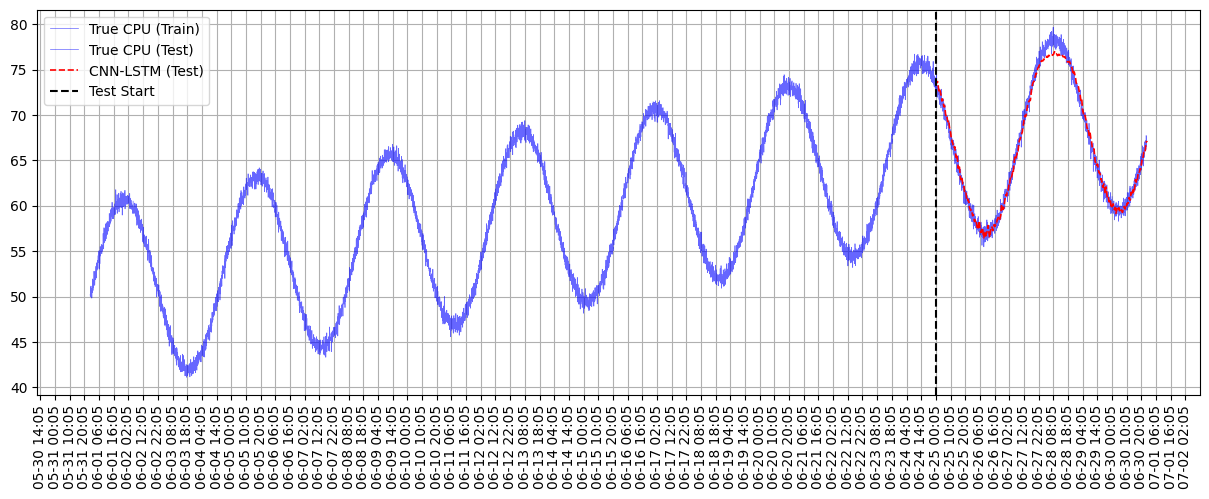

In [ ]:
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(y_true_inv[:,0].flatten(), index=test_time_index) # test data (True)

test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(15,5))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600)) # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.show()


Result for Moving Average
MAE : 0.5517
RMSE: 0.6882

Result for CNN-LSTM
MAE : 0.5966
RMSE: 0.7623


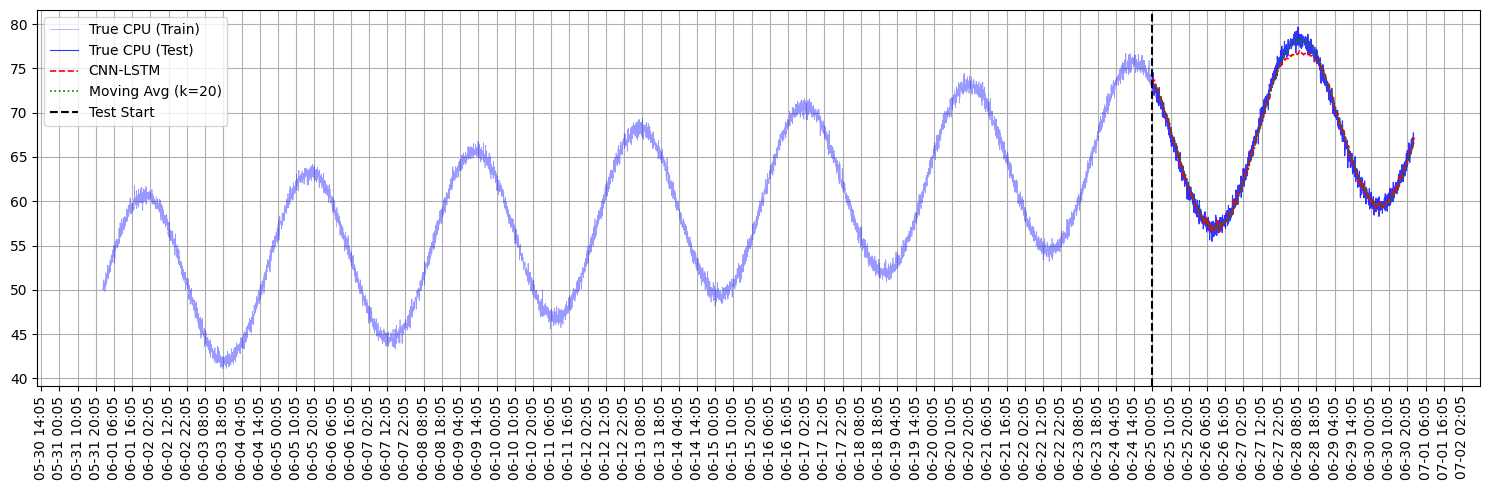

In [ ]:
# 정확도 분석

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Moving Average 방식
k = 20  # 최근 20 step 평균 (원하는 값으로 조절)
moving_avg_pred = []

for i in range(k, len(test_series_true)):
    moving_avg_pred.append(np.mean(test_series_true[i-k:i]))  # k개 평균

moving_avg_pred_series = pd.Series(moving_avg_pred, index=test_time_index[k:])  # k step 이후부터 가능


true_vals = test_series_true.values
cnn_pred_vals = test_series_pred.values[:len(true_vals)]  # 길이 맞춤

mae_cnn = mean_absolute_error(true_vals, cnn_pred_vals)
rmse_cnn = np.sqrt(mean_squared_error(true_vals, cnn_pred_vals))
r2_cnn = r2_score(true_vals, cnn_pred_vals)

true_vals_ma = true_vals[k:]  # k step 이후부터만 비교 가능
mae_ma = mean_absolute_error(true_vals_ma, moving_avg_pred)
rmse_ma = np.sqrt(mean_squared_error(true_vals_ma, moving_avg_pred))
r2_ma = r2_score(true_vals_ma, moving_avg_pred)

print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")
# print(f"R²  : {r2_ma:.4f}")

print("\nResult for CNN-LSTM")
print(f"MAE : {mae_cnn:.4f}")
print(f"RMSE: {rmse_cnn:.4f}")
# print(f"R²  : {r2_cnn:.4f}")

fig, ax = plt.subplots(figsize=(15,5))

plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.4, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.8, linewidth=0.8)
plt.plot(test_series_pred, label="CNN-LSTM", color="red", linestyle="--", linewidth=1.2)
plt.plot(moving_avg_pred_series, label=f"Moving Avg (k={k})", color="green", linestyle=":", linewidth=1.2)

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")  # test 시작선

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))  # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # (k, mae, rmse, complexity)

for k in k_list:
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # k step 이후
    true_vals_ma = test_series_true.values[k:]

    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    complexity = len(test_series_true) * k

    results.append((k, mae, rmse, complexity))

results_arr = np.array(results)
k_values = results_arr[:,0]
mae_values = results_arr[:,1]
rmse_values = results_arr[:,2]
complexity_values = results_arr[:,3]

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(k_values, mae_values, marker='o', label="MAE", color='blue')
ax1.plot(k_values, rmse_values, marker='s', label="RMSE", color='red')
ax1.set_xlabel("Moving Average Window k")
ax1.set_ylabel("Error")
ax1.grid(True)
ax1.legend(loc="upper left")

# complexity
ax2 = ax1.twinx()
ax2.plot(k_values, complexity_values, marker='^', label="Complexity (Ops ~ N*k)", color='green', linestyle='--')
ax2.set_ylabel("Complexity")
ax2.legend(loc="upper right")

plt.title("k vs MAE/RMSE & Complexity")
plt.tight_layout()
plt.show()

for k, mae, rmse, comp in results:
    print(f"k={int(k):2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{int(comp)} ops")


NameError: name 'test_series_true' is not defined

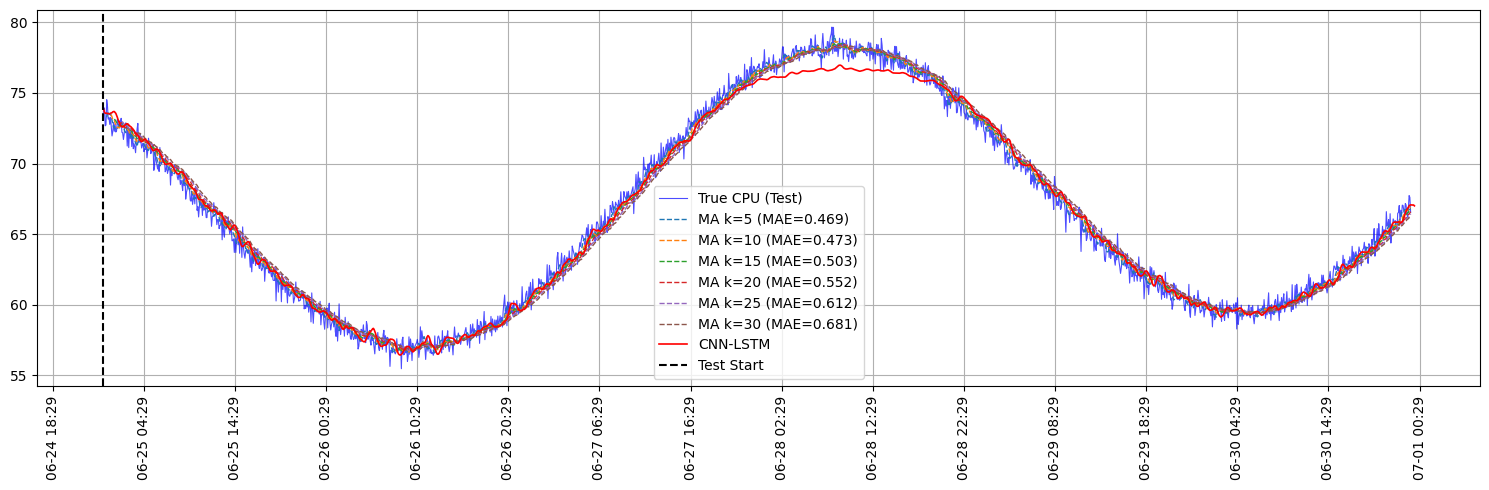

=== Moving Average 성능 비교 ===
k= 5  MAE=0.4693  RMSE=0.5886
k=10  MAE=0.4728  RMSE=0.5958
k=15  MAE=0.5032  RMSE=0.6329
k=20  MAE=0.5517  RMSE=0.6882
k=25  MAE=0.6119  RMSE=0.7564
k=30  MAE=0.6807  RMSE=0.8298


In [ ]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # MAE/RMSE 저장 리스트
fig, ax = plt.subplots(figsize=(15,5))

# True 값은 한 번만 그리기
ax.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.7, linewidth=0.8)

for k in k_list:
    # Moving Average 계산
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # Series 생성 (index 맞춤)
    ma_pred_series = pd.Series(ma_pred, index=test_time_index[k:])

    # 성능 측정
    true_vals_ma = test_series_true.values[k:]  # k step 이후만 비교
    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    # 저장
    results.append((k, mae, rmse))

    # 그래프에 추가
    ax.plot(ma_pred_series, label=f"MA k={k} (MAE={mae:.3f})", linestyle="--", linewidth=1)

# CNN-LSTM도 같이 비교
ax.plot(test_series_pred, label="CNN-LSTM", color="red", linewidth=1.2)

# X축 tick 설정
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# k별 성능 출력
print("=== Moving Average 성능 비교 ===")
for k, mae, rmse in results:
    print(f"k={k:2d}  MAE={mae:.4f}  RMSE={rmse:.4f}")


## 3. LSTM + sliding window (1)

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 5분 단위 한 달 데이터 생성
np.random.seed(42)
days = 60
points_per_day = 24 * 12  # 하루 288 포인트 (5분 단위)
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')

# CPU 패턴 (주기적인 패턴 + 노이즈 + 증가 추세)
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# sliding window function, lookback_time만큼을 보고 predict_time만큼 추정
def create_sliding_window_data(data, lookback_time, predict_time):
    X, y = [], []
    for i in range(len(data) - lookback_time - predict_time + 1):
        x_window = data[i:i+lookback_time]
        y_value  = data[i+lookback_time+predict_time-1]
        X.append(x_window)
        y.append(y_value)
    return np.array(X), np.array(y)

lookback = 20  # 과거 20개 step 사용
predict_horizon = 1  # 1 step ahead 예측
X, y = create_sliding_window_data(df['cpu'].values, lookback, predict_horizon)

# LSTM 입력 차원 맞추기: (샘플수, time_steps, feature=1)
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"input shape: {x_train.shape}, output shape: {y_train.shape}")

# LSTM 모델 정의
cell_size = 128
timesteps = lookback
feature = 1

model = Sequential(name="CPU_LSTM")
model.add(LSTM(cell_size, input_shape=(timesteps, feature), return_sequences=True))
model.add(LSTM(cell_size))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.0005),
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

model.summary()

history = model.fit(x_train, y_train,
                    epochs=5, batch_size=16,
                    validation_data=(x_test, y_test),
                    verbose=1)

y_pred = model.predict(x_test)

# 스케일 inverse
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

input shape: (13808, 20, 1), output shape: (13808, 1)


/tmp/ipython-input-5-1753720425.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "CPU_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
863/863 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 1361.0516 - mean_absolute_error: 33.8945 - root_mean_squared_error: 36.1643 - val_loss: 254.5061 - val_mean_absolute_error: 14.4513 - val_root_mean_squared_error: 15.9532
Epoch 2/5
863/863 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - loss: 88.7865 - mean_absolute_error: 7.6707 - root_mean_squared_error: 9.4094 - val_loss: 111.0274 - val_mean_absolute_error: 8.2772 - val_root_mean_squared_error: 10.5370
Epoch 3/5
863/863 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - loss: 72.3036 - mean_absolute_error: 7.0895 - root_mean_squared_error: 8.5025 - val_loss: 109.5355 - val_mean_absolute_error: 8.2037 - val_root_mean_squared_error: 10.4659
Epoch 4/5
863/863 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - loss: 54.9715 - mean_absolute_error: 5.6894 - root_mean_squared_error: 7.3426 - val_loss: 20.1789 - val_mean_absolute_error: 2.7711 - val_root_mean_squared_error: 4.4921
Epoch 5/5
863/863 ━━━━━━━━━━━━━━━━━━━━ 46s 38ms/step - loss: 2.7853 - mean_absolute_error

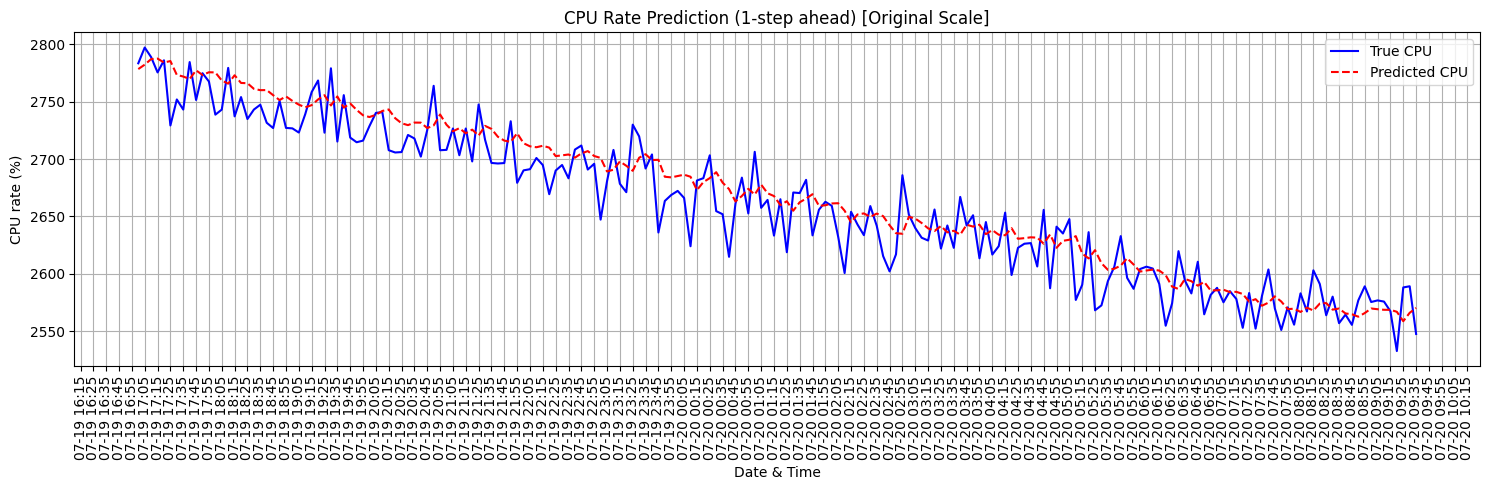

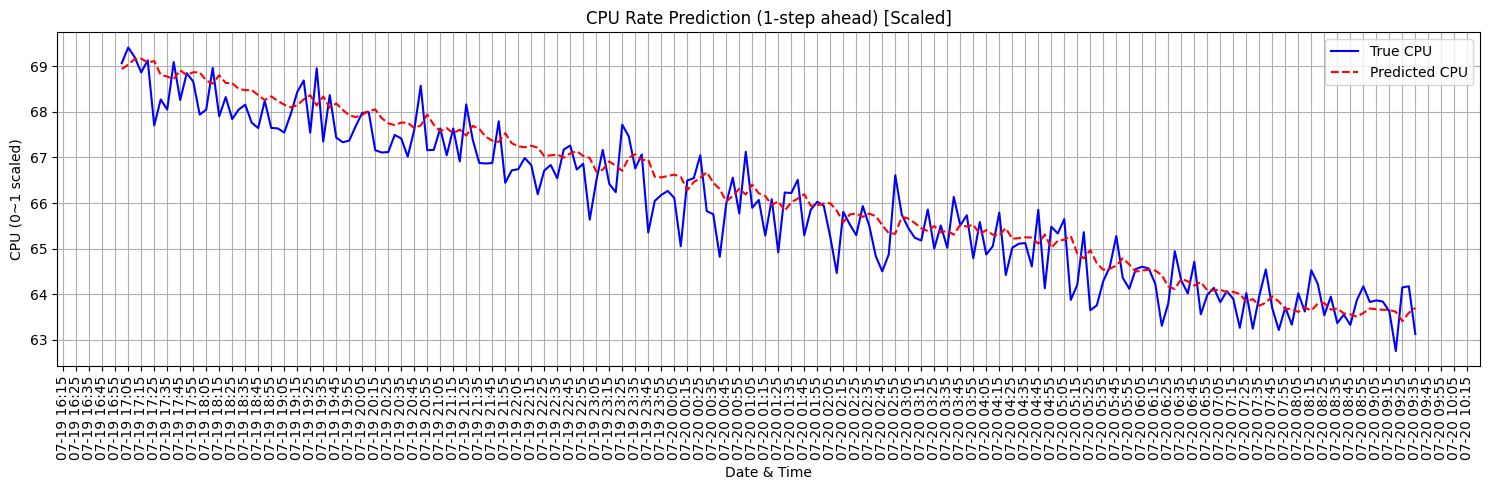

In [ ]:
import matplotlib.dates as mdates

test_start_idx = len(x_train) + lookback
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

y_test_inv_series = pd.Series(y_test_inv.flatten(), index=test_time_index)
y_pred_inv_series = pd.Series(y_pred_inv.flatten(), index=test_time_index)
y_test_series = pd.Series(y_test.flatten(), index=test_time_index)
y_pred_series = pd.Series(y_pred.flatten(), index=test_time_index)

def plot_with_time(x_true, x_pred, ylabel, title):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(x_true, label='True CPU', color='blue')
    ax.plot(x_pred, label='Predicted CPU', color='red', linestyle='--')


    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))   # 10분 간격
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # 월-일 시:분 표시

    # x축 라벨 세로(90도 회전)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

    plt.xlabel('Date & Time')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# plot_with_time(y_test_inv_series[:200], y_pred_inv_series[:200],
#                ylabel='CPU rate (%)',
#                title='CPU Rate Prediction (1-step ahead) [Original Scale]')

# plot_with_time(y_test_series[:200], y_pred_series[:200],
#                ylabel='CPU (0~1 scaled)',
#                title='CPU Rate Prediction (1-step ahead) [Scaled]')

plot_with_time(y_test_inv_series[200:400], y_pred_inv_series[200:400],
               ylabel='CPU rate (%)',
               title='CPU Rate Prediction (1-step ahead) [Original Scale]')

plot_with_time(y_test_series[200:400], y_pred_series[200:400],
               ylabel='CPU (0~1 scaled)',
               title='CPU Rate Prediction (1-step ahead) [Scaled]')

In [4]:
import matplotlib.dates as mdates

# ✅ Train 구간 시간 인덱스 (LSTM은 Test만 있으니 Train 구간은 원본 데이터에서 가져옴)
train_end_idx = len(x_train) + lookback
train_time_index = df.index[lookback:train_end_idx]

# ✅ Train 구간 실제값 (스케일 복원 전 or 후 선택)
train_series_true = pd.Series(
    scaled_cpu.flatten()[lookback:train_end_idx],  # ← MinMaxScaler 적용된 값
    index=train_time_index
)

# ✅ Test 구간 (이미 준비된 Series 사용)
test_series_true = y_test_inv_series
test_series_pred = y_pred_inv_series

# ✅ Train+Test 연결 그래프
plt.figure(figsize=(15,5))

# Train 실제값
plt.plot(train_series_true.index, train_series_true.values,
         label="True CPU (Train)", color="blue", alpha=0.4, linewidth=0.5)

# Test 실제값
plt.plot(test_series_true.index, test_series_true.values,
         label="True CPU (Test)", color="blue", alpha=0.8, linewidth=0.8)

# Test 예측값
plt.plot(test_series_pred.index, test_series_pred.values,
         label="LSTM Predicted (Test)", color="red", linestyle="--", linewidth=1.2)

# Test 시작선
plt.axvline(test_series_true.index[0], color="black", linestyle="--", label="Test Start")

# ✅ x축 시간 tick 설정 (10시간=600분 간격)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90)

plt.xlabel("Date & Time")
plt.ylabel("CPU usage (%)")
plt.title("Train + Test CPU Prediction (LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'x_train' is not defined

In [ ]:
# test부분만 확대

In [ ]:
# mov_avg와 비교, window크기별 분석


## 그래프 모양 변경 (비대칭 sin파)